# Import library

In [ ]:
import wfdb
import matplotlib.pyplot as plt
import os
import pandas as pd
import neurokit2 as nk
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.signal import butter, filtfilt, iirnotch
from scipy.signal import welch
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import seaborn as sns
import gc
import os
import antropy as ant
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
mapping  = pd.read_csv('/physionet.org/files/ecg-arrhythmia/1.0.0/ConditionNames_SNOMED-CT.csv')

# tạo dict ánh xạ {SNOMED_CT: FullName}
snomed_map = dict(zip(mapping['Snomed_CT'], mapping['Full Name']))

#base dir path
base_dir = '/physionet.org/files/ecg-arrhythmia/1.0.0/'
records_path = os.path.join(base_dir, "RECORDS")
records = [] #address of files of 1 object
with open(records_path,"r") as f:
    folders = [line.strip() for line in f.readlines()]
print("Số folder:", len(folders))
for folder in folders:
    file = os.path.join(base_dir,folder,"RECORDS")
    with open(file,"r") as f:
        records.extend(os.path.join(base_dir,folder,line.strip()) for line in f.readlines())


records_test = [records[i] for i in range(50)]
print("số file test", len(records_test))

Số folder: 100
số file test 50


In [87]:

def visualize_qrs_delineation(ecg_signal, r_peaks, sampling_rate=500, n_beats=5):
    """
    Vẽ chi tiết QRS complex để kiểm tra detect Q, R, S có đúng không
    """
    # Chạy delineation
    _, waves = nk.ecg_delineate(ecg_signal, {'ECG_R_Peaks': r_peaks}, sampling_rate)
    
    # Lấy các điểm
    qrs_onsets = waves.get('ECG_Q_Peaks', [])
    r_peaks_detect = r_peaks
    qrs_offsets = waves.get('ECG_S_Peaks', [])
    
    # Tính QRS duration
    if len(qrs_onsets) > 0 and len(qrs_offsets) > 0:
        # Chỉ lấy những cặp Q-S hợp lệ
        valid_pairs = []
        for q, s in zip(qrs_onsets, qrs_offsets):
            if not np.isnan(q) and not np.isnan(s) and s > q:
                valid_pairs.append((q, s))
        
        if len(valid_pairs) > 0:
            qrs_durations = [(s - q) / sampling_rate * 1000 for q, s in valid_pairs]
            qrs_mean = np.mean(qrs_durations)
            qrs_std = np.std(qrs_durations)
        else:
            qrs_mean, qrs_std = 0, 0
    else:
        qrs_mean, qrs_std = 0, 0
    
    # === VẼ 2 LOẠI BIỂU ĐỒ ===
    
    # --- BIỂU ĐỒ 1: TOÀN BỘ TÍN HIỆU ---
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    
    # Plot tín hiệu đầy đủ
    axes[0].plot(ecg_signal, 'k-', linewidth=0.5, alpha=0.7, label='ECG Signal')
    
    # Đánh dấu R-peaks
    axes[0].scatter(r_peaks_detect, ecg_signal[r_peaks_detect], 
                   c='red', s=80, marker='o', label='R-peaks', zorder=5)
    
    # Đánh dấu Q (onset)
    if len(qrs_onsets) > 0:
        valid_q = [q for q in qrs_onsets if not np.isnan(q)]
        if len(valid_q) > 0:
            valid_q = np.array(valid_q).astype(int)
            axes[0].scatter(valid_q, ecg_signal[valid_q], 
                           c='green', s=60, marker='^', label='Q (onset)', zorder=5)
    
    # Đánh dấu S (offset)
    if len(qrs_offsets) > 0:
        valid_s = [s for s in qrs_offsets if not np.isnan(s)]
        if len(valid_s) > 0:
            valid_s = np.array(valid_s).astype(int)
            axes[0].scatter(valid_s, ecg_signal[valid_s], 
                           c='blue', s=60, marker='v', label='S (offset)', zorder=5)
    
    axes[0].set_xlabel('Sample Index', fontsize=12)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].set_title(f'Full ECG Signal - QRS Duration: {qrs_mean:.1f} ± {qrs_std:.1f} ms', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(loc='upper right', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # --- BIỂU ĐỒ 2: ZOOM VÀO TỪNG NHỊP ---
    # Chọn n_beats nhịp đầu tiên để zoom
    beats_to_show = min(n_beats, len(r_peaks_detect))
    
    for i in range(beats_to_show):
        r_idx = r_peaks_detect[i]
        
        # Lấy window xung quanh R-peak (±200ms)
        window = int(0.2 * sampling_rate)
        start = max(0, r_idx - window)
        end = min(len(ecg_signal), r_idx + window)
        
        # Tìm Q và S tương ứng với R-peak này
        q_idx = None
        s_idx = None
        
        if len(qrs_onsets) > i and not np.isnan(qrs_onsets[i]):
            q_idx = int(qrs_onsets[i])
        if len(qrs_offsets) > i and not np.isnan(qrs_offsets[i]):
            s_idx = int(qrs_offsets[i])
        
        # Subplot cho từng nhịp
        ax = plt.subplot(2, beats_to_show, beats_to_show + i + 1)
        
        # Vẽ tín hiệu
        time_axis = np.arange(start, end)
        ax.plot(time_axis, ecg_signal[start:end], 'k-', linewidth=2)
        
        # Đánh dấu R
        ax.scatter(r_idx, ecg_signal[r_idx], c='red', s=100, marker='o', 
                  label='R', zorder=5)
        
        # Đánh dấu Q
        if q_idx is not None and start <= q_idx < end:
            ax.scatter(q_idx, ecg_signal[q_idx], c='green', s=80, marker='^', 
                      label='Q', zorder=5)
            # Vẽ đường dọc từ Q
            ax.axvline(q_idx, color='green', linestyle='--', alpha=0.5)
        
        # Đánh dấu S
        if s_idx is not None and start <= s_idx < end:
            ax.scatter(s_idx, ecg_signal[s_idx], c='blue', s=80, marker='v', 
                      label='S', zorder=5)
            # Vẽ đường dọc từ S
            ax.axvline(s_idx, color='blue', linestyle='--', alpha=0.5)
        
        # Tính QRS duration cho nhịp này
        if q_idx is not None and s_idx is not None:
            qrs_dur = (s_idx - q_idx) / sampling_rate * 1000
            ax.set_title(f'Beat {i+1}\nQRS: {qrs_dur:.1f}ms', fontsize=10)
            
            # Highlight vùng QRS
            ax.axvspan(q_idx, s_idx, alpha=0.2, color='yellow')
        else:
            ax.set_title(f'Beat {i+1}\nQRS: N/A', fontsize=10)
        
        ax.set_xlabel('Sample', fontsize=9)
        ax.set_ylabel('Amp', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # === IN THỐNG KÊ ===
    print("\n" + "="*60)
    print("📊 QRS DELINEATION STATISTICS")
    print("="*60)
    print(f"✅ Total R-peaks detected: {len(r_peaks_detect)}")
    print(f"✅ Valid Q-peaks detected: {len([q for q in qrs_onsets if not np.isnan(q)])}")
    print(f"✅ Valid S-peaks detected: {len([s for s in qrs_offsets if not np.isnan(s)])}")
    print(f"\n📏 QRS Duration:")
    print(f"   Mean: {qrs_mean:.2f} ms")
    print(f"   Std:  {qrs_std:.2f} ms")
    
    if qrs_mean > 120:
        print(f"\n⚠️  WARNING: QRS duration > 120ms")
        if qrs_std > 20:
            print(f"   ⚠️  High STD ({qrs_std:.1f}ms) → Possibly NOISE or detection error")
        else:
            print(f"   ✅ Low STD ({qrs_std:.1f}ms) → Possibly real Bundle Branch Block")
    elif qrs_mean > 0:
        print(f"\n✅ QRS duration is NORMAL (60-100ms expected)")
    
    print("="*60 + "\n")
    
    return qrs_mean, qrs_std


In [97]:

        
LEADS = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]

FEATURES_PER_LEAD = [
    # RR stats
    "RR_mean","RR_std","RR_median","RR_min","RR_max","RR_range","RR_IQR","RR_CV",
    # Time-domain HRV
    "RMSSD","pNN50","pNN20","HRV_triang",
    # Nonlinear RR
    "SampEn_RR","ApEn_RR",
    "Poincare_SD1","Poincare_SD2","Poincare_ratio",
    # Morphology / amplitude
    "R_amp_mean","R_amp_std","R_amp_min","R_amp_max",
    "QRS_energy_mean","QRS_energy_std",
    # Signal-level stats
    "Signal_skew","Signal_kurtosis","Signal_entropy",
    "Zero_cross_rate",
    # Quality
    "ECG_quality_mean","ECG_quality_std",
    # Flag
    "Missing_flag"
]

def empty_lead_features(lead):
    d = {f"{lead}_{f}": np.nan for f in FEATURES_PER_LEAD}
    d[f"{lead}_Missing_flag"] = 1
    return d

def shannon_entropy(x, bins=100):
    x = np.asarray(x)
    hist, _ = np.histogram(x, bins=bins, density=True)
    hist = hist[hist > 0]          # loại các giá trị zero để tránh log(0)
    return -np.sum(hist * np.log2(hist))


# kiểm tra tín hiệu ecg có bị ngược không, nếu có: nghịch đảo
def check_and_fix_inverted_signal(ecg_signal):
    """
    Kiểm tra và sửa tín hiệu bị đảo ngược dựa trên skewness.
    Nếu skewness âm rõ rệt => khả năng cao QRS hướng xuống.
    """
    skew = stats.skew(ecg_signal)
    
    if skew < -0.5:
        return -ecg_signal, True
    else:
        return ecg_signal, False

# tìm R-peaks với 5 phương pháp trong neurokit2
def detect_r_peaks_smart(ecg_signal, sampling_rate=500, lead_name="ECG"):
    """
    Phát hiện R-peaks bằng nhiều thuật toán phổ biến và tự động kiểm định chất lượng tín hiệu.
    
    ✅ Dùng 5 phương pháp phổ biến.
    ✅ Chạy hết để đối chiếu, không in ra.
    ✅ Nếu độ lệch chuẩn giữa số peaks lớn → cảnh báo nhiễu hoặc arrhythmia.
    ✅ Nếu hầu hết không phát hiện được → tín hiệu lỗi (bỏ).
    
    Returns:
        {
            'ok': bool,                  # True nếu tín hiệu hợp lệ
            'reason': str,               # Lý do cảnh báo hoặc lỗi
            'consensus_method': str,     # Phương pháp chọn cuối cùng
            'n_peaks': int,
            'r_peaks': np.ndarray,
            'heart_rate': float
        }
    """
    
    methods = ['neurokit', 'pantompkins1985', 'hamilton2002', 'elgendi2010', 'kalidas2017']
    results = {}
    
    for method in methods:
        try:
            _, info = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate, method=method)
            rpeaks = info.get('ECG_R_Peaks', [])
            
            if len(rpeaks) > 1:
                rr = np.diff(rpeaks) / sampling_rate
                # ✅ Lọc outliers (30-200 bpm)
                rr_filtered = rr[(rr >= 0.3) & (rr <= 2.0)]
                if len(rr_filtered) >= 2:
                    hr = 60 / np.mean(rr_filtered)
                    hr_std = 60 * np.std(rr_filtered) / (np.mean(rr_filtered) ** 2)
                    
                    # Kiểm tra HR hợp lý
                    if 30 <= hr <= 200:
                        results[method] = {
                            'n_peaks': len(rpeaks), 
                            'r_peaks': rpeaks, 
                            'hr': hr,
                            'hr_std': hr_std,
                            'ok': True, 
                            'info': info
                        }
                    else:
                        results[method] = {'n_peaks': len(rpeaks), 'r_peaks': rpeaks, 'hr': None, 'hr_std': None, 'ok': False}
                else:
                    results[method] = {'n_peaks': len(rpeaks), 'r_peaks': rpeaks, 'hr': None, 'hr_std': None, 'ok': False}
            else:
                results[method] = {'n_peaks': 0, 'r_peaks': [], 'hr': None, 'ok': False}
        
        except Exception as e:
            results[method] = {'n_peaks': 0, 'r_peaks': [], 'hr': None, 'ok': False, 'error': str(e), 'info': {}}
    
    # --- Phân tích kết quả tổng hợp ---
    success_counts = [v['n_peaks'] for v in results.values() if v['ok']]
    fail_ratio = sum(1 for v in results.values() if not v['ok']) / len(methods)
    
    # Không có phương pháp nào phát hiện được R-peaks
    if len(success_counts) == 0 or np.median(success_counts) == 0:
        return {
            'ok': False,
            'reason': f"⚠️ {lead_name}: No R-peaks detected by any method.",
            'consensus_method': None,
            'n_peaks': 0,
            'r_peaks': None,
            'heart_rate': None,
            'info': {}
        }
    
    # Nếu phần lớn phương pháp thất bại → tín hiệu có vấn đề
    if fail_ratio > 0.6:
        return {
            'ok': False,
            'reason': f"⚠️ {lead_name}: Most methods failed to detect R-peaks → possibly bad signal.",
            'consensus_method': None,
            'n_peaks': 0,
            'r_peaks': None,
            'heart_rate': None,
              'info': {}
        }

    # Nếu độ lệch chuẩn số peaks giữa các phương pháp cao
    std = np.std(success_counts)
    median = np.median(success_counts)
    if median > 0 and std > 0.5 * median:
        return {
            'ok': False,
            'reason': f"⚠️ {lead_name}: Inconsistent R-peak detection (std too large → noise or arrhythmia).",
            'consensus_method': None,
            'n_peaks': int(median),
            'r_peaks': None,
            'heart_rate': None,
            'info': {}
        }

    # --- Nếu ổn định → chọn phương pháp có số peaks gần median nhất ---
    consensus_method = min(
        results.items(), 
        key=lambda kv: abs(kv[1]['n_peaks'] - median)
    )[0]
    
    chosen = results[consensus_method]
    
    return {
        'ok': True,
        'reason': None,
        'consensus_method': consensus_method,
        'n_peaks': chosen['n_peaks'],
        'r_peaks': chosen['r_peaks'],
        'heart_rate': chosen['hr']
    }


#Loại bỏ nhiễu trong tín hiệu : nhiễu cơ sở (chuyển động, hô hấp) + nhiễu nguồn điện + nhiễu cơ điện + chuẩn hóa biên độ + đảo ngược chuỗi ecg
def preprocess_ecg(signal, fs=500, notch_freq=50.0, smooth=False):
    """
    Tiền xử lý tín hiệu ECG:
      - Loại bỏ baseline wander (<0.5 Hz)
      - Loại bỏ nhiễu nguồn điện (50/60 Hz)
      - Lọc nhiễu cơ (>40 Hz)
      - Chuẩn hóa biên độ (z-score)
      - (Tùy chọn) Làm mượt nhẹ

    Parameters
    ----------
    signal : array-like
        Tín hiệu ECG gốc (1 kênh)
    fs : int
        Tần số lấy mẫu (Hz)
    notch_freq : float
        Tần số nguồn điện (50 hoặc 60 Hz)
    smooth : bool
        Có làm mượt nhẹ (moving average) sau cùng không

    Returns
    -------
    clean_signal : np.ndarray
        Tín hiệu ECG đã tiền xử lý
    """

    signal = np.asarray(signal, dtype=float)
    if np.isnan(signal).any():
        signal = np.nan_to_num(signal, nan=0.0)

    nyquist = fs / 2

    # 1️⃣ Loại baseline wander (<0.5 Hz) bằng highpass
    b_hp, a_hp = butter(5, 1 / nyquist, btype='high')
    filtered = filtfilt(b_hp, a_hp, signal)

    # 2️⃣ Loại nhiễu cơ (>40 Hz) bằng lowpass
    b_lp, a_lp = butter(4, 35 / nyquist, btype='low')
    filtered = filtfilt(b_lp, a_lp, filtered)

    # 3️⃣ Loại nhiễu nguồn điện (50 hoặc 60 Hz)
    # (Notch filter Q=30 cho cân bằng tốt)
    b_notch, a_notch = iirnotch(notch_freq / nyquist, Q=30)
    filtered = filtfilt(b_notch, a_notch, filtered)

    # 4️⃣ Chuẩn hóa biên độ (z-score)
    mean = np.mean(filtered)
    std = np.std(filtered)
    if std == 0:
        std = 1e-6  # tránh chia 0
    normalized = (filtered - mean) / std

    # 5️⃣ Kiểm tra tín hiệu có bị đảo ngược không
    corrected_signal, inverted = check_and_fix_inverted_signal(normalized)

    # 5️⃣ (Tùy chọn) Làm mượt nhẹ để giảm nhiễu nhỏ lẻ
    # 6️⃣ (Tùy chọn) Làm mượt nhẹ
    if smooth:
        win_size = int(fs * 0.02)  # 20 ms
        win_size = max(win_size, 3)
        kernel = np.ones(win_size) / win_size
        smoothed = np.convolve(corrected_signal, kernel, mode='same')
        clean_signal = smoothed
    else:
        clean_signal = corrected_signal

    return clean_signal



###########################################################################################
#extract feature data: P, SQR, T,  (xử lý dữ liệu trong 1 đạo ecg trong bản ghi)

def extract_features_single_lead(signal, fs, lead):
    try:
        clean = preprocess_ecg(signal, fs=fs)

        # 1) Detect R-peaks
        res = detect_r_peaks_smart(clean, sampling_rate=fs, lead_name=lead)
        if (not res["ok"]) or (res["r_peaks"] is None) or (len(res["r_peaks"]) < 6):
            # quá ít nhịp -> không tính RR được
            return empty_lead_features(lead)

        rpeaks = np.array(res["r_peaks"], dtype=int)
        rr = np.diff(rpeaks) / fs  # đơn vị: giây

        if len(rr) < 4:
            return empty_lead_features(lead)

        # 2) RR stats
        diff_rr = np.diff(rr)
        rr_mean = np.mean(rr)
        rr_std = np.std(rr)
        rr_median = np.median(rr)
        rr_min = np.min(rr)
        rr_max = np.max(rr)
        rr_range = rr_max - rr_min
        rr_iqr = np.percentile(rr, 75) - np.percentile(rr, 25)
        rr_cv = rr_std / rr_mean if rr_mean > 0 else np.nan

        # 3) Time-domain HRV
        rmssd = np.sqrt(np.mean(diff_rr**2))
        pnn50 = np.mean(np.abs(diff_rr) > 0.050)
        pnn20 = np.mean(np.abs(diff_rr) > 0.020)

        hist, _ = np.histogram(rr, bins=50)
        hrv_triang = np.sum(hist) / np.max(hist) if np.max(hist) > 0 else np.nan

        # 4) Nonlinear RR
        try:
            sampen = ant.sample_entropy(rr)
            if isinstance(sampen, (list, tuple, np.ndarray)):
                sampen = float(sampen[0])
        except Exception:
            sampen = np.nan

        try:
            apen = ant.app_entropy(rr)
            if isinstance(apen, (list, tuple, np.ndarray)):
                apen = float(apen[0])
        except Exception:
            apen = np.nan

        # Poincaré SD1, SD2
        sd1 = np.sqrt(np.var(diff_rr) / 2.0)
        sd2_raw = 2*np.var(rr) - np.var(diff_rr)/2.0
        sd2 = np.sqrt(sd2_raw) if sd2_raw > 0 else np.nan
        if not np.isnan(sd2) and sd2 > 0:
            poincare_ratio = sd1 / sd2
        else:
            poincare_ratio = np.nan

        # 5) Morphology: R amplitude + QRS energy
        r_amp = clean[rpeaks]

        w = int(0.05 * fs)  # 50 ms
        energies = []
        for r in rpeaks:
            left = max(0, r - w)
            right = min(len(clean), r + w)
            seg = clean[left:right]
            energies.append(np.sum(seg**2))
        energies = np.array(energies)

        # 6) Signal-level statistics
        zc = np.sum(np.diff(np.sign(clean)) != 0) / len(clean)
        sig_skew = skew(clean)
        sig_kurt = kurtosis(clean)
        sig_entropy = shannon_entropy(clean)

        # 7) ECG quality (neurokit2)
        quality = nk.ecg_quality(clean, rpeaks=rpeaks, sampling_rate=fs)
        q_mean = np.mean(quality)
        q_std = np.std(quality)

        # 8) Build feature dict cho lead này
        d = {
            f"{lead}_RR_mean": rr_mean,
            f"{lead}_RR_std": rr_std,
            f"{lead}_RR_median": rr_median,
            f"{lead}_RR_min": rr_min,
            f"{lead}_RR_max": rr_max,
            f"{lead}_RR_range": rr_range,
            f"{lead}_RR_IQR": rr_iqr,
            f"{lead}_RR_CV": rr_cv,

            f"{lead}_RMSSD": rmssd,
            f"{lead}_pNN50": pnn50,
            f"{lead}_pNN20": pnn20,
            f"{lead}_HRV_triang": hrv_triang,

            f"{lead}_SampEn_RR": sampen,
            f"{lead}_ApEn_RR": apen,
            f"{lead}_Poincare_SD1": sd1,
            f"{lead}_Poincare_SD2": sd2,
            f"{lead}_Poincare_ratio": poincare_ratio,

            f"{lead}_R_amp_mean": np.mean(r_amp),
            f"{lead}_R_amp_std": np.std(r_amp),
            f"{lead}_R_amp_min": np.min(r_amp),
            f"{lead}_R_amp_max": np.max(r_amp),

            f"{lead}_QRS_energy_mean": np.mean(energies),
            f"{lead}_QRS_energy_std": np.std(energies),

            f"{lead}_Signal_skew": sig_skew,
            f"{lead}_Signal_kurtosis": sig_kurt,
            f"{lead}_Signal_entropy": sig_entropy,
            f"{lead}_Zero_cross_rate": zc,

            f"{lead}_ECG_quality_mean": q_mean,
            f"{lead}_ECG_quality_std": q_std,

            f"{lead}_Missing_flag": 0,
        }

        return d

    except Exception as e:
        # optional: print(f"{lead} crash: {e}")
        return empty_lead_features(lead)

    

def extract_ecg_features_12lead(ecg_dict, fs):
    all_feats = {}
    for lead in LEADS:
        signal = ecg_dict.get(lead, None)
        if signal is None:
            # nếu thiếu hẳn lead trong file
            feats = empty_lead_features(lead)
        else:
            feats = extract_features_single_lead(signal, fs, lead)
        all_feats.update(feats)
    return all_feats


###########################################################################################
# xử lý dữ liệu trong 1 bản ghi 
LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

def process_record(record_path):
    # base metadata
    base_row = {
        "record_name": record_path,
        "sex": None,
        "age": None,
        "fs": None,
        "duration_sec": None,
        "diagnose": None,
        "has_AF": None,
        "record_path": record_path,
    }
    try:
        # Đọc tín hiệu ECG
        rec = wfdb.rdrecord(record_path)
        name = rec.record_name
        fs = rec.fs
        sig_len = rec.sig_len
        duration = sig_len / fs

        # ---- Metadata ----
        age, sex, dx = None, None, []
        for c in rec.comments:
            c = c.strip()
            if c.startswith('Age:'):
                try:
                    age = int(c.split(':')[1].strip())
                except:
                    age = None
            elif c.startswith('Sex:'):
                sex = c.split(':')[1].strip()
            elif c.startswith('Dx:'):
                dx = [d.strip() for d in c.split(':')[1].split(',')]

        # Nhãn AF dựa vào mã SNOMED
        has_AF = '164889003' in dx if isinstance(dx, list) else False

        # ---- Build ECG dict for 12 leads ----
        ecg_dict = {lead: rec.p_signal[:, idx] for idx, lead in enumerate(LEADS)}

        # ---- Extract FEATURES for 12 leads (480 features FIXED) ----
        features_12lead = extract_ecg_features_12lead(ecg_dict, fs)

        # ---- Gộp metadata + features thành 1 row ----
        row = {
            **base_row,
            "record_name": name,
            "sex": sex,
            "age": age,
            "fs": fs,
            "duration_sec": duration,
            "diagnose": ','.join(dx) if isinstance(dx, list) else dx,
            "has_AF": has_AF,
            "record_path": record_path
        }

        row.update(features_12lead)  # Thêm 480 feature / record

        return row

    except Exception as e:
        print(f"⚠️ Lỗi ở record {record_path}: {e}")
        empty_feats = {}
        for lead in LEADS:
            empty_feats.update(empty_lead_features(lead))

        row = {**base_row, **empty_feats}
        row["error"] = str(e)
        return row


def extract_all_records(records, output_csv="ecg_features.csv", max_workers=None, chunk_size=50):
    """
    - records: danh sách các file ECG (.hea không có đuôi)
    - output_csv: nơi ghi kết quả
    - max_workers: số tiến trình song song
    - chunk_size: số record ghi ra file mỗi lần
    """
    if max_workers is None:
        max_workers = max(1, os.cpu_count() - 1)

    print(f"⚙️ Sử dụng {max_workers} tiến trình song song")
    # Định nghĩa full header cố định
    meta_cols = ["record_name", "sex", "age", "fs", "duration_sec", "diagnose", "has_AF", "record_path"]
    feature_cols = [f"{lead}_{f}" for lead in LEADS for f in FEATURES_PER_LEAD]
    all_cols = meta_cols + feature_cols + ["error"]

    rows_buffer = []
    header_written = False

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_record, r) for r in records]

        for f in tqdm(as_completed(futures), total=len(records), desc="Processing ECG"):
            result = f.result()
            rows_buffer.append(result)

            # Khi đủ chunk_size bản ghi thì ghi ra CSV
            if len(rows_buffer) >= chunk_size:
                df = pd.DataFrame(rows_buffer)
                df = df.reindex(columns=all_cols)  # đảm bảo đủ cột + đúng thứ tự
                df.to_csv(output_csv, mode='a', index=False, header=not header_written)
                header_written = True
                rows_buffer.clear()  # xóa khỏi RAM
                gc.collect()

    # Ghi phần còn lại nếu chưa đủ chunk cuối
    if rows_buffer:
        df = pd.DataFrame(rows_buffer)
        df = df.reindex(columns=all_cols)
        df.to_csv(output_csv, mode='a', index=False, header=not header_written)
        rows_buffer.clear()
        gc.collect()

    print(f"✅ Đã hoàn thành trích xuất ECG. Kết quả lưu tại: {output_csv}")

extract_all_records(records, output_csv="ecg_features.csv", max_workers=6, chunk_size=25)

⚙️ Sử dụng 6 tiến trình song song


Processing ECG: 100%|██████████| 9741/9741 [18:23<00:00,  8.82it/s]


✅ Đã hoàn thành trích xuất ECG. Kết quả lưu tại: ecg_features.csv


# EDA

In [3]:
df = pd.read_csv("ecg_features.csv")

# 1. Drop metadata
cols_drop = ["record_name", "record_path", "diagnose", "error"]
df = df.drop(columns=[c for c in cols_drop if c in df.columns])

# 2. Normalize sex
df["sex"] = df["sex"].astype(str).str.strip().map({"Male": 1, "Female": 0})

# 3. Normalize has_AF
df["has_AF"] = df["has_AF"].astype(str).str.strip().map({"True": 1, "False": 0}).astype("Int64")

# 4. Drop entropy features
entropy_rr_cols = [c for c in df.columns if "SampEn_RR" in c or "ApEn_RR" in c]
df = df.drop(columns=entropy_rr_cols)

# 5. Fill NA using median
df = df.fillna(df.median(numeric_only=True))

# 6. Check again
print("error" in df.columns)
print(df.isna().sum().sort_values(ascending=False).head())

print("Loaded:", df.shape)


/tmp/ipykernel_4291/1790651568.py:1: DtypeWarning: Columns (2,3,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247) have mixed types. Specify dtype option on import or set low_memor

False
I_Poincare_SD2        94
I_Poincare_ratio      94
I_Zero_cross_rate     85
I_Signal_kurtosis     85
I_ECG_quality_mean    85
dtype: int64
Loaded: (9853, 341)


In [99]:
df["has_AF"].value_counts(normalize=True)


has_AF
0    0.822605
1    0.177395
Name: proportion, dtype: Float64

In [100]:
df.describe().T.sort_values("std", ascending=False).head(40)


,count,mean,std,min,25%,50%,75%,max
V1_QRS_energy_mean,9741.0,266.013492,117.830582,1.247643,181.100821,251.353671,351.046082,666.73331
III_QRS_energy_mean,9741.0,240.776525,114.137421,3.226819,158.705462,229.751977,317.627307,596.238726
aVL_QRS_energy_mean,9741.0,241.17774,112.821681,3.393675,159.261353,228.93399,316.566174,612.802029
aVF_QRS_energy_mean,9741.0,241.499784,110.796284,2.282363,163.595972,230.259597,315.144113,630.566911
V4_QRS_energy_mean,9741.0,276.711095,109.546939,0.820786,197.290274,262.019586,349.96558,612.302166
V5_QRS_energy_mean,9741.0,283.457621,108.049596,1.519256,205.158484,269.891298,360.770644,617.730727
V3_QRS_energy_mean,9741.0,258.888568,105.642661,0.578806,182.776917,245.37636,323.252982,675.195062
V6_QRS_energy_mean,9741.0,280.222341,104.478548,3.054291,202.686077,267.517343,356.008109,631.526374
V2_QRS_energy_mean,9741.0,253.092744,104.004588,0.580533,178.94974,238.811494,318.595364,673.645861
II_QRS_energy_mean,9741.0,251.176021,102.916766,2.041253,178.835436,240.308775,318.833275,604.205938


In [101]:
corr = df.corr(numeric_only=True)

# lấy upper triangle của ma trận để tránh trùng lặp (A,B) và (B,A)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# tìm cột nào có tương quan > 0.95
high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if abs(upper.loc[row, col]) > 0.95
]

len(high_corr_pairs), high_corr_pairs[:10]

(282,
 [('I_RR_median', 'I_RR_mean', np.float64(0.9815711716097155)),
  ('I_RR_range', 'I_RR_std', np.float64(0.9751442877884495)),
  ('I_RMSSD', 'I_RR_std', np.float64(0.9565976240321047)),
  ('I_RMSSD', 'I_RR_range', np.float64(0.9527836799748322)),
  ('I_Poincare_SD1', 'I_RMSSD', np.float64(0.9992308103438686)),
  ('I_Poincare_SD2', 'I_RR_std', np.float64(0.9794266914761113)),
  ('II_RR_mean', 'I_RR_mean', np.float64(0.9546562744577766)),
  ('II_RR_median', 'I_RR_median', np.float64(0.9557754220997828)),
  ('II_RR_median', 'II_RR_mean', np.float64(0.9843687108591165)),
  ('II_RR_max', 'I_RR_max', np.float64(0.963429500635992))])

40 feature có phương sai lớn nhất

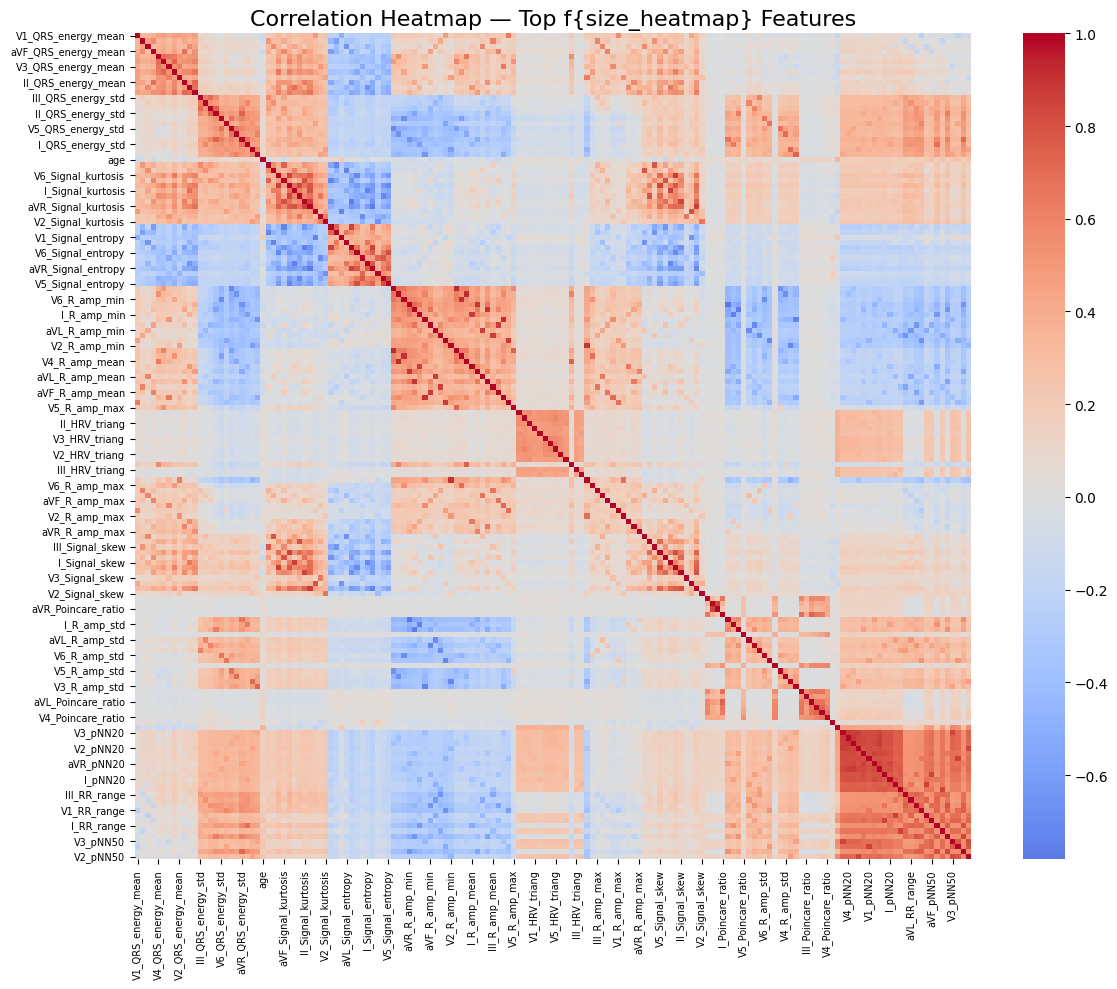

In [102]:
# lấy top 40 feature based on std
size_heatmap = 160
top_features = df.std().sort_values(ascending=False).head(size_heatmap).index

corr_top40 = corr.loc[top_features, top_features]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_top40, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap — Top f{size_heatmap} Features", fontsize=16)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

Heatmap theo lead

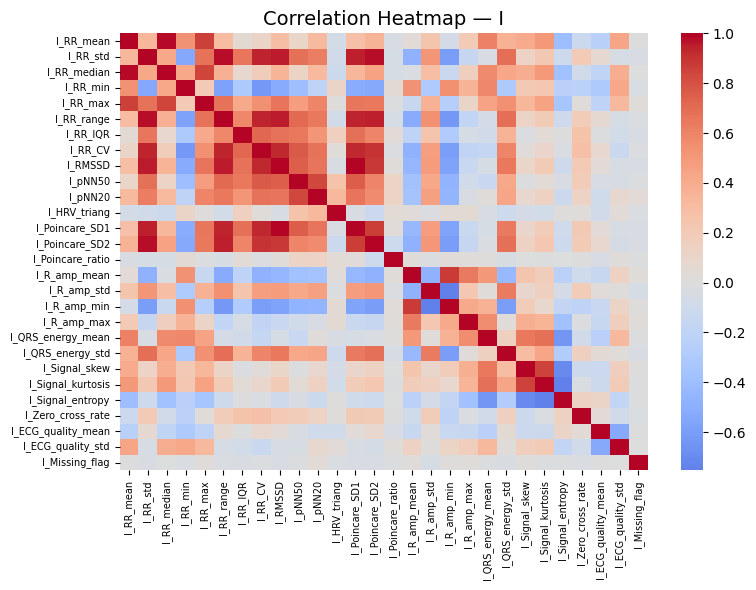

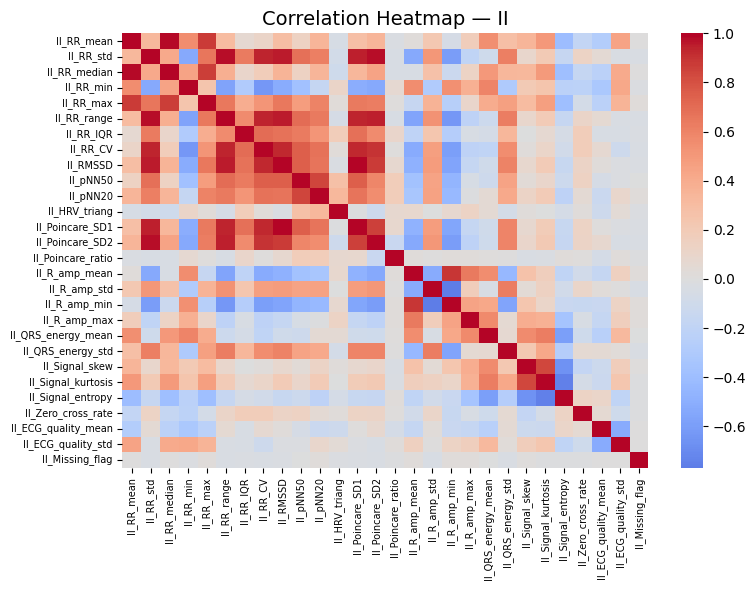

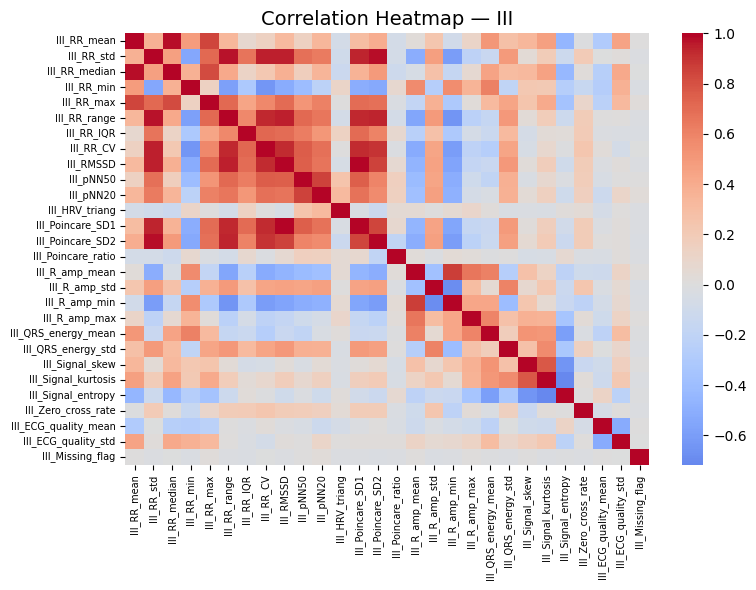

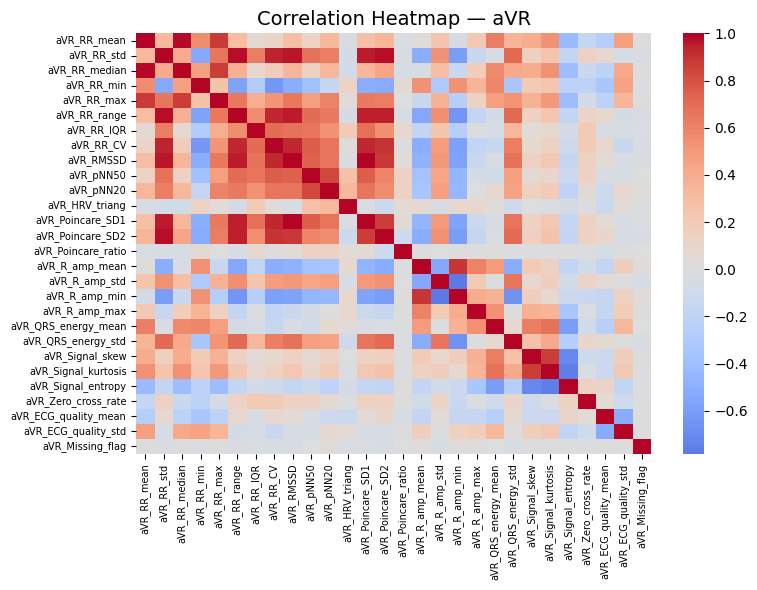

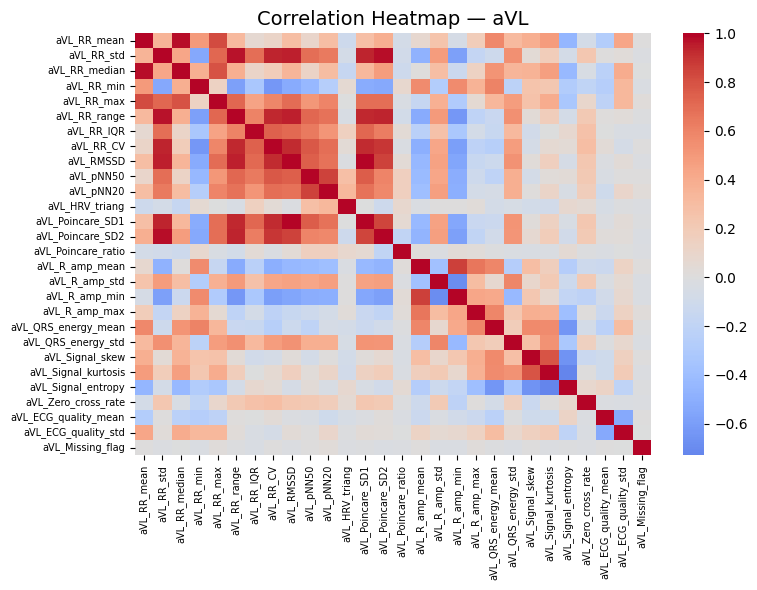

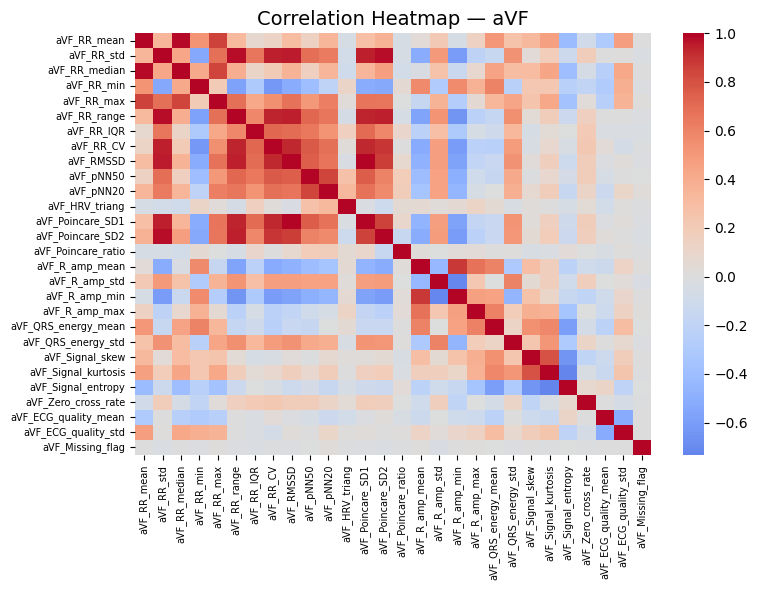

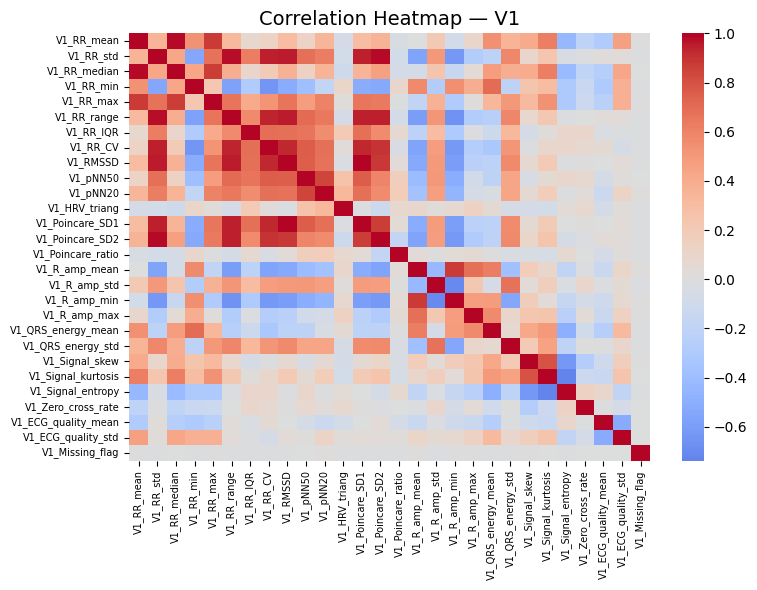

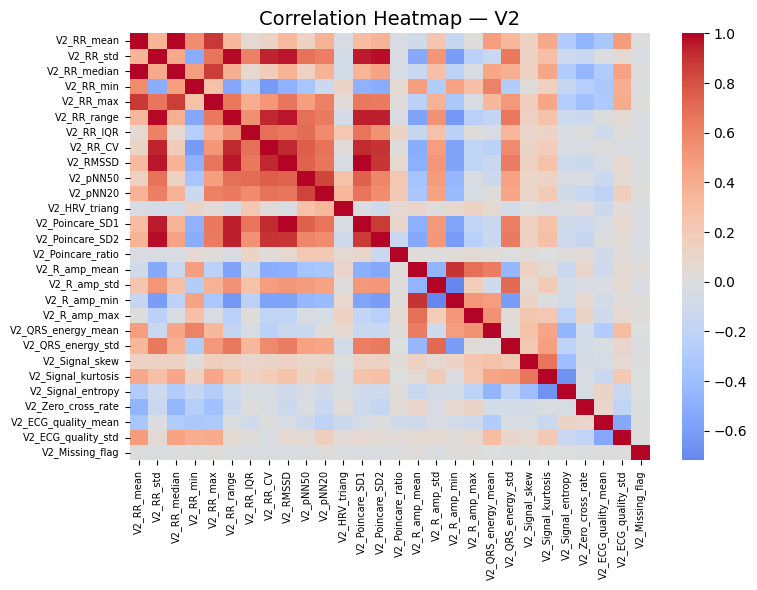

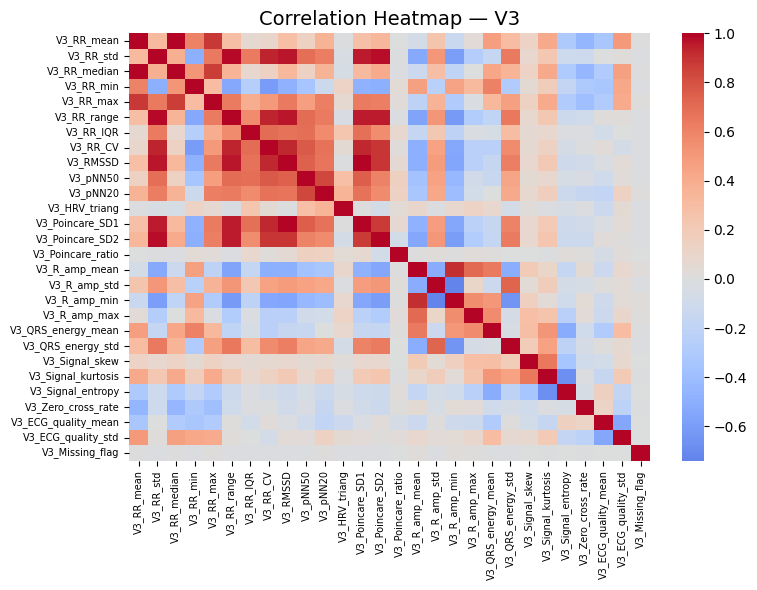

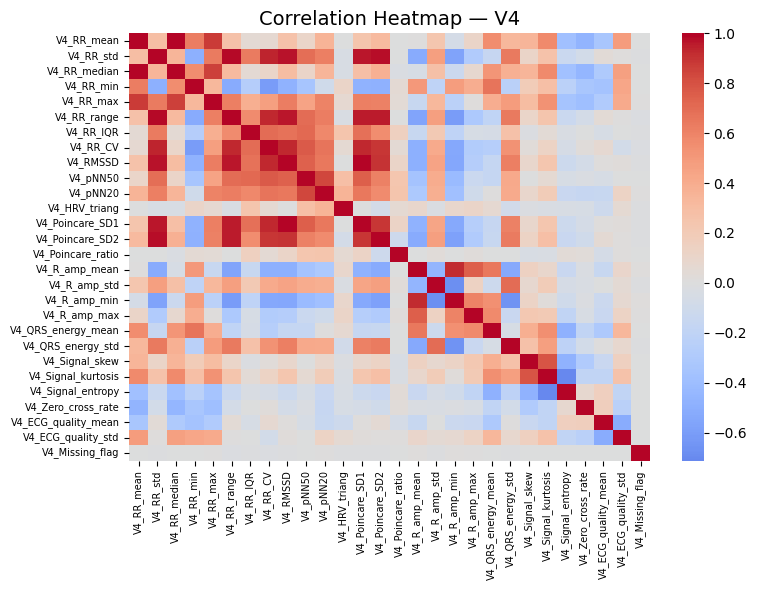

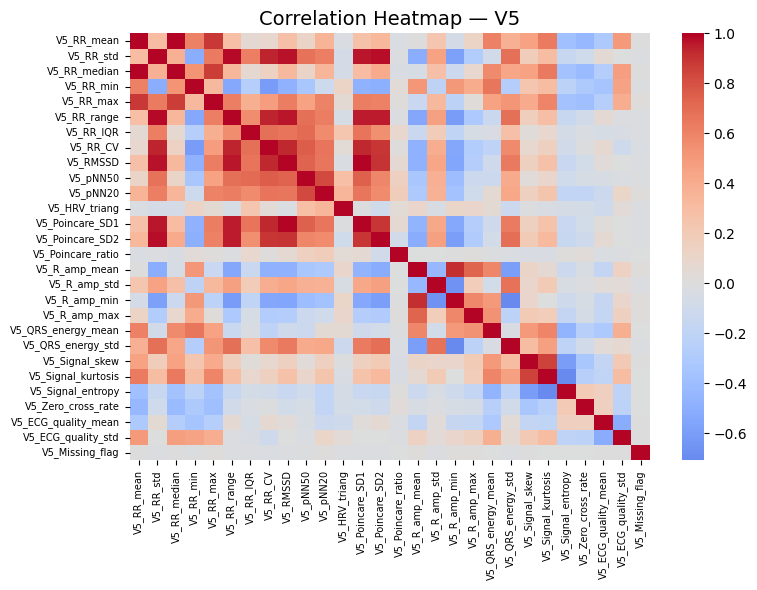

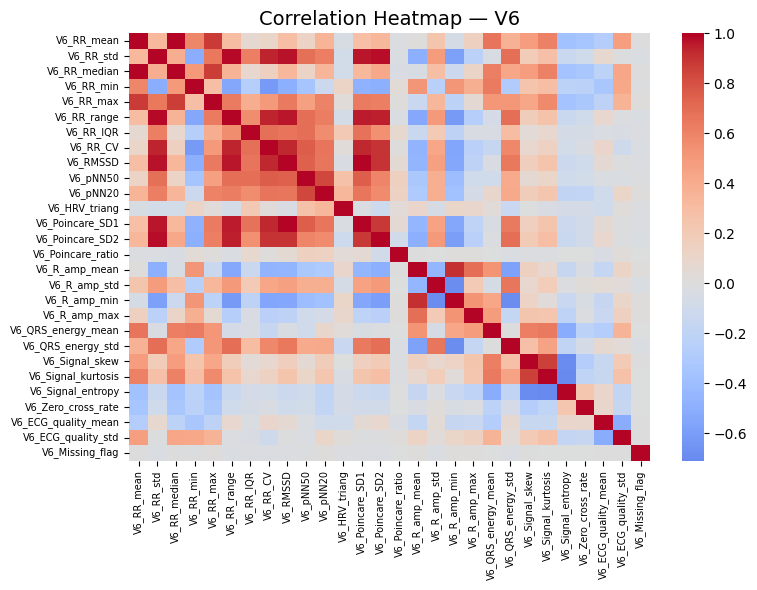

In [103]:
LEADS = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]

for lead in LEADS:
    lead_cols = [c for c in df.columns if c.startswith(lead + "_")]

    if len(lead_cols) == 0:
        continue

    corr_lead = corr.loc[lead_cols, lead_cols]

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_lead, cmap="coolwarm", center=0)
    plt.title(f"Correlation Heatmap — {lead}", fontsize=14)
    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout()
    plt.show()


20 cặp tương quan mạnh nhất

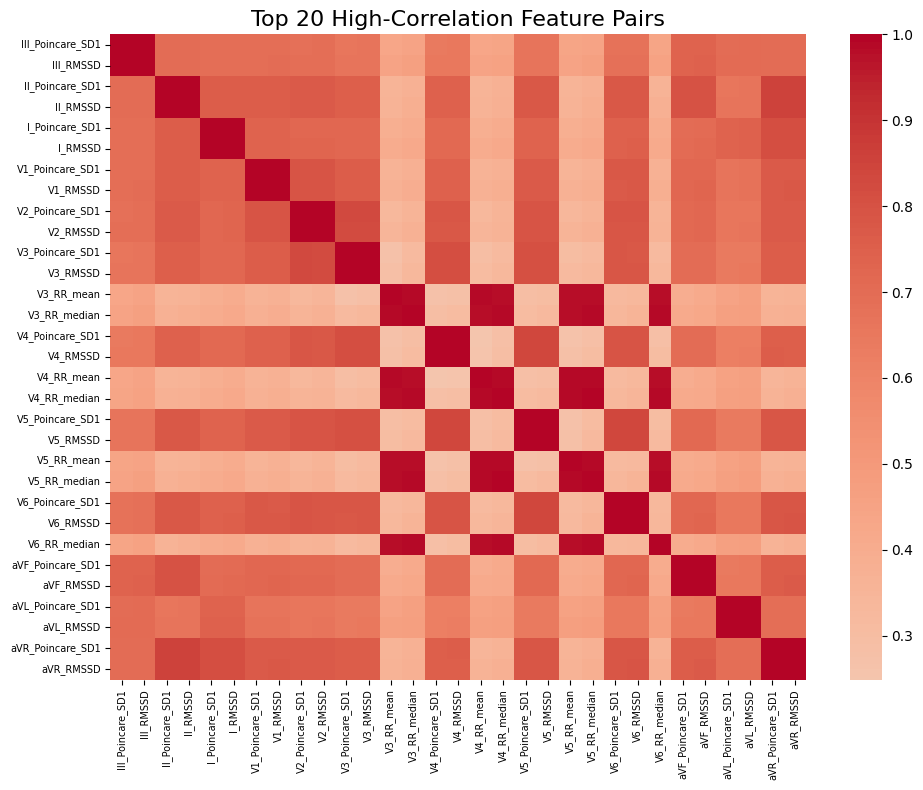

In [ ]:
# lấy upper triangle
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# tìm các cặp có tương quan cao
pairs = []
for col in upper.columns:
    for row in upper.index:
        val = upper.loc[row, col]
        if abs(val) > 0.9:
            pairs.append((row, col, val))

# sort theo độ lớn tương quan
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)[:]

# lấy danh sách feature
top_pairs_features = sorted(list(set([p[0] for p in pairs_sorted] + 
                                     [p[1] for p in pairs_sorted])))

corr_pairs = corr.loc[top_pairs_features, top_pairs_features]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_pairs, cmap="coolwarm", center=0, annot=False)
plt.title("Top 20 High-Correlation Feature Pairs", fontsize=16)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

# Pipeline 

In [105]:
import numpy as np
import pandas as pd

# ============================================
# 1) CUSTOM TRANSFORMER: CORRELATION FILTER
# ============================================

from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.to_drop = None

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        corr = df.corr().abs()

        # Upper triangle
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

        # Select features to drop
        self.to_drop = [
            column for column in upper.columns 
            if any(upper[column] > self.threshold)
        ]

        print(f"[INFO] CorrelationFilter removed {len(self.to_drop)} features.")
        return self

    def transform(self, X):
        df = pd.DataFrame(X)
        if self.to_drop:
            return df.drop(columns=self.to_drop, errors="ignore").values
        return df.values


# ============================================
# 2) LOAD DATA
# ============================================

# df must already be cleaned:
# - no entropy features
# - normalized sex & AF
# - NA filled
# - no metadata columns

X = df.drop(columns=["has_AF"])
y = df["has_AF"].astype(int)


# ============================================
# 3) COMPLETE PIPELINE
# ============================================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.95)),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),          # keep 95% variance
    ("clf", RandomForestClassifier(
        n_estimators=300, 
        random_state=42,
        class_weight="balanced"
    ))
])

# ============================================
# 4) TRAIN/TEST SPLIT + TRAIN MODEL
# ============================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(y_test, y_pred))


# ============================================
# 5) CROSS-VALIDATION 5-FOLD
# ============================================

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    pipeline, X, y, 
    cv=5, scoring="f1"
)

print("\n===== 5-FOLD CV F1-SCORE =====")
print(cv_scores)
print("Mean F1:", cv_scores.mean())


# ============================================
# 6) INSPECT MODEL (optional)
# ============================================

# số chiều sau PCA
print("\nPCA components:", pipeline.named_steps["pca"].n_components_)

# feature bị drop do tương quan cao
print("\nDropped features:", pipeline.named_steps["corr_filter"].to_drop)


# ============================================
# 7) DEMO: USE PIPELINE TO PREDICT 1 SAMPLE
# ============================================

sample = X_test.iloc[0:1]
pred = pipeline.predict(sample)
print("\nPredict sample:", pred)


[INFO] CorrelationFilter removed 76 features.

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1603
           1       0.83      0.65      0.73       346

    accuracy                           0.91      1949
   macro avg       0.88      0.81      0.84      1949
weighted avg       0.91      0.91      0.91      1949

[INFO] CorrelationFilter removed 76 features.
[INFO] CorrelationFilter removed 76 features.
[INFO] CorrelationFilter removed 76 features.
[INFO] CorrelationFilter removed 76 features.
[INFO] CorrelationFilter removed 75 features.

===== 5-FOLD CV F1-SCORE =====
[0.75577558 0.77022654 0.72756933 0.7458194  0.72413793]
Mean F1: 0.7447057549921232

PCA components: 125

Dropped features: ['I_RR_median', 'I_RR_range', 'I_RMSSD', 'I_Poincare_SD1', 'I_Poincare_SD2', 'II_RR_mean', 'II_RR_median', 'II_RR_max', 'II_RR_range', 'II_RMSSD', 'II_Poincare_SD1', 'II_Poincare_SD2', 'III_RR_median', 'II

xgboost

In [106]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

# ============================================
# 1) CUSTOM TRANSFORMER: CORRELATION FILTER
# ============================================

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.to_drop = None

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        corr = df.corr().abs()

        # Upper triangle
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

        # Select features to drop
        self.to_drop = [
            column for column in upper.columns
            if any(upper[column] > self.threshold)
        ]

        print(f"[INFO] CorrelationFilter removed {len(self.to_drop)} features.")
        return self

    def transform(self, X):
        df = pd.DataFrame(X)
        if self.to_drop:
            return df.drop(columns=self.to_drop, errors="ignore").values
        return df.values


# ============================================
# 2) CHUẨN BỊ DỮ LIỆU (df đã clean sẵn)
# ============================================

# df: dataframe đã:
#  - bỏ record_name, record_path, diagnose, error
#  - sex -> 0/1
#  - has_AF -> 0/1
#  - drop SampEn, ApEn
#  - fill NA

X = df.drop(columns=["has_AF"])
y = df["has_AF"].astype(int)

# scale_pos_weight = (số mẫu class 0) / (số mẫu class 1)
n_neg = (y == 0).sum()
n_pos = (y == 1).sum()
scale_pos_weight = n_neg / n_pos
print(f"[INFO] n_neg={n_neg}, n_pos={n_pos}, scale_pos_weight={scale_pos_weight:.2f}")


# ============================================
# 3) TẠO PIPELINE XGBOOST + PCA + CORRFILTER
# ============================================

xgb_clf = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",      # hoặc "auc"
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

pipeline_xgb = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.95)),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("clf", xgb_clf)
])


# ============================================
# 4) TRAIN/TEST SPLIT + TRAIN & EVALUATE
# ============================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42,
    stratify=y
)

pipeline_xgb.fit(X_train, y_train)

y_pred = pipeline_xgb.predict(X_test)

print("\n===== XGBOOST CLASSIFICATION REPORT =====")
print(classification_report(y_test, y_pred))


# ============================================
# 5) CROSS-VALIDATION 5-FOLD (F1-score cho lớp 1)
# ============================================

cv_scores = cross_val_score(
    pipeline_xgb, X, y,
    cv=5,
    scoring="f1"   # f1 cho positive class (1)
)

print("\n===== XGBOOST 5-FOLD CV F1-SCORE =====")
print(cv_scores)
print("Mean F1:", cv_scores.mean())


# ============================================
# 6) INSPECT PIPELINE
# ============================================

# Số chiều sau PCA
print("\nPCA components:", pipeline_xgb.named_steps["pca"].n_components_)

# Các feature bị loại do tương quan cao
print("\nDropped (correlated) features:")
print(pipeline_xgb.named_steps["corr_filter"].to_drop[:30], "...")
print("Total dropped:", len(pipeline_xgb.named_steps["corr_filter"].to_drop))

# Demo predict 1 sample
sample = X_test.iloc[0:1]
pred = pipeline_xgb.predict(sample)
print("\nSample true label:", int(y_test.iloc[0]), "→ predicted:", int(pred[0]))


[INFO] n_neg=8013, n_pos=1728, scale_pos_weight=4.64
[INFO] CorrelationFilter removed 76 features.

===== XGBOOST CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1603
           1       0.80      0.94      0.87       346

    accuracy                           0.95      1949
   macro avg       0.89      0.95      0.92      1949
weighted avg       0.95      0.95      0.95      1949

[INFO] CorrelationFilter removed 76 features.
[INFO] CorrelationFilter removed 76 features.
[INFO] CorrelationFilter removed 76 features.
[INFO] CorrelationFilter removed 76 features.
[INFO] CorrelationFilter removed 75 features.

===== XGBOOST 5-FOLD CV F1-SCORE =====
[0.88195387 0.89251701 0.87566138 0.89466484 0.84375   ]
Mean F1: 0.87770941843477

PCA components: 125

Dropped (correlated) features:
['I_RR_median', 'I_RR_range', 'I_RMSSD', 'I_Poincare_SD1', 'I_Poincare_SD2', 'II_RR_mean', 'II_RR_median', 'II_RR_max', 'II_R